In [212]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from bs4 import BeautifulSoup
import requests
import random
import pickle
from matplotlib.lines import Line2D
import re
import spacy
import json
from spacy import displacy
import collections
from collections import Counter
from collections import OrderedDict
from tqdm.notebook import tqdm as tqdm_notebook
from transformers import DistilBertModel, DistilBertTokenizer, logging
from itertools import islice
import itertools
import torch
import sys
import os
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Environment settings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
nlp = spacy.load('en_core_web_trf')
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

In [3]:
# Own functinos
from web_crawler import web_crawler
from predict_model import loadBERT
from predict_model import SpanPredictor as classify

In [4]:
# Model
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')

CPU Success


In [5]:
# Glossary
glossary = pickle.load(open('../data/glossaries/FNA_glossary.pkl', 'rb'))
glossary['leaf'] += ['leave']
glossary['trunk'] += ['crownshaft']

In [6]:
compound_list = [
    'fertile', 'sterile',
    'male', 'female', 'bisexual', 'hermaphroditic', 
    'basal', 'developed', 'definitive', 'prebasic', 'juvenile', 'new',
    'primary', 'secondary', 'main',
    'upper', 'lower', 'greater', 'dorsal', 'alternate', 'lesser', 'apex', 'outer', 'less', 'main', 'median', 'frontal',
    'central', 'outermost', 'outer', 'inner', 'uppermost', 'median', 'dorsal', 'central', 'lateral',
    'young', 'mature', 'individual', 'old',
    'opposite', 'single', 'paired', 'malar',
    'winter', 'summer', 'autumn', 'spring',
    'breeding',
    
]

rubbish_list = [
    '.', ',', '-', '..', '...', '', 
]

In [7]:
measurements_list = [
    'mm', 'cm', 'm', 'km',
    'milimeter', 'centimeter', 'meter', 'kilometer',
    'milimetre', 'centimetre', 'metre', 'kilometre',
    'inch', 'foot', 'yard', 'mile',
    'wide', 'long', 'broad', 'tall',
    'length', 'form',
]

In [8]:
def text_preparation(species, text):
    cleaners = [(r'(?<!\d)\.(?!\d)', ' '),
                (r'\s×\s', ' times '),
                (r'\s+c\s+', ' '),
                (r'â\x80\x93', ' to '),
                (r'\xa0', ' '),
                (r'\x97', ''),
                (r'\s{2,}', ' '),
                (r'(\D)(\.)', r'\1 '),
                (r'(\d)(\.)(\D)', r'\1 \3'),
                (r'(long,)', r'long and'),
                (r'(wide,)', r'wide and'),
               ]
    
    species_parts = species.split()
    candidates = [' '.join(species_parts[:idx+1]) for idx, _ in enumerate(species_parts)]
    #candidates += [
    #        f'{species_parts[0][0]}. {species_parts[1]}'
    #    ]
    candidates.reverse()
    for candidate in candidates:
        try:
            text = re.sub(candidate, 'the species', text)
        except:
            continue # Skip species with brackets for now
    for (cleaner, replacement) in cleaners:
        text = re.sub(cleaner, replacement, text)    
    text = f'{text.strip()}.'
    return text.capitalize()


def dict_sentence(t):
    sentence_dict = {}
    for child in t.children:
        # Exceptions
        if (
            child.dep_ not in [
                'det', 'cc', 'punct', 
                'poss', 
                'nmod', 'ccomp', # Gives to many errors
                'conj',
                'prt', # Verb things
            ]
            and child.pos_ not in [
                'DET', 'PUNCT',
                'PART',
                'ADV',
                'SCONJ',
                'PRON',
            ]
            and child.lemma_ not in [
                'on', 'of', 'as', 'from', 'by', 'onto',
            ]
        ):
            items = dict_sentence(child)
            sentence_dict[child] = items 
    return sentence_dict

def undict_to_tuples(d, acc = []):
    if d == {}:
        yield acc
    else:
        for k, v in d.items():
            yield from undict_to_tuples(v, acc + [k,])
            
def undict_to_pairs(d):
    for k,v in d.items():
        for subk in v:
            yield (k, subk)
        yield from undict_to_pairs(v)

def dict_sentence_parent(t):
    if t.dep_ in [
        'nsubj', 'nsubjpass', 'relcl',
    ]:
        parent = next(tok for tok in t.ancestors)
        parent_dict = dict_sentence(parent)
        del parent_dict[t]
        return parent_dict

def update_nested_dict(main_dict, new_dict):
    for name, rc_dict in new_dict.items():
        main_dict.setdefault(name, {}).update(rc_dict)
    return main_dict       

def extract_compounds(t, doc):
    head = None
    if t.dep_ == 'compound':
        t = next(t.ancestors)
    indices = [child.i for child in t.children
               if child.dep_ == 'compound'
               or child.lemma_ in compound_list
               and child.i < t.i]
    indices.append(t.i)
    indices.sort(reverse=True)
    compounds  = []
    for idx in indices:
        compounds.append(doc[idx : t.i + 1])
    return compounds    
            
            
def check_existance(t):
    item = None
    for mainpart in glossary.keys():
        if t.lemma_ in compound_list:
            item = None
        #elif t.pos_ != 'NOUN':
        elif t.pos_ not in ['NOUN', 'PROPN']:
            item = None
        elif t.lemma_.lower().strip() in glossary[mainpart]:
            item = mainpart            
    return item


def clean_compounds(item_list, doc):
    new_item_list = []
    new_item_list.append(item_list[0])
    for item in item_list[1:]:
        item_orig = item
        if type(item) == spacy.tokens.token.Token:
            item = item
        else:
            item = item.root
        #if item.dep_ == 'prep':
        #    new_item_list += item_list[1:]
        #    break
        if (
            item.lemma_ in compound_list 
            or item.dep_ == 'compound'
        ):
            continue
        elif item.pos_ == 'NOUN':
            compound = extract_compounds(item, doc)[-1]
            if len(compound) == 1:
                #print(compound)
                compound = compound.root
            new_item_list.append(item_orig)
        else:
            new_item_list.append(item_orig)
    return new_item_list

def clean_measurements(info_list):
    new_item_list = []
    for item_list in info_list:
        
        nums = [t.dep_ for t in item_list if type(t) == spacy.tokens.token.Token if t.pos_ == 'NUM']
        if len(nums) > 1:
            temp = []
            for item, future in zip(item_list, item_list[1:]):        
                if type(item) == spacy.tokens.span.Span:
                    temp.append(item)
                elif item.pos_ == 'NUM' and future.pos_ == 'NUM':
                    new_item_list.append(temp + [item])
                    new_item_list.append(temp + [future])
                else:
                    temp.append(item)
        else:
            new_item_list.append(item_list)
    return new_item_list


def clean_prepositions_of(info_list):
    new_info_lists = []
    for info in info_list:
        new_item_list = []
        used = []
        for item in info:
            item_orig = item
            if type(item) == spacy.tokens.token.Token:
                item = item
            else:
                item = item.root
            prep_of = next((t for t in item.children if t.lemma_ == 'of'), None)
            if prep_of:
                child = next((t for t in prep_of.children if t.dep_ == 'pobj'), None)
            if prep_of and child:
                #print(item, prep_of, child)
                new_item_list.append(doc[item.i : child.i + 1])
            else:
                new_item_list.append(item_orig)
        new_info_lists.append(new_item_list)
    return new_info_lists


def clean_prepositions_on(info_list):
    new_info_lists = []
    #print(info_list)
    for info in info_list:
        new_item_list = []
        used = []
        for item in info:
            item_orig = item
            #print(item)
            if type(item) == spacy.tokens.token.Token:
                item = item
            else:
                item = item.root
            prep = next((t for t in item.children if t.lemma_ == 'on'), None)
            #print(prep_on)
            if prep:
                child = next((t for t in prep.children if t.dep_ == 'pobj'), None)
            if prep and child:
                #print(item, prep, child)
                new_item_list.append(doc[item.i : child.i + 1])
            else:
                new_item_list.append(item_orig)
        new_info_lists.append(new_item_list)
    return new_info_lists

def clean_prepositions_in(info_list):
    new_info_lists = []
    for info in info_list:
        new_item_list = []
        used = []
        for item in info:
            if item.lemma_ == 'in':
                break
            new_item_list.append(item)
        new_info_lists.append(new_item_list)
    return new_info_lists


def clean_prepositions_with(info_list):
    new_info_lists = []
    for info in info_list:
        new_item_list = []
        used = []
        for item in info:
            if item.lemma_ == 'with':
                continue
            new_item_list.append(item)
        new_info_lists.append(new_item_list)
    return new_info_lists
        
def create_relation(part, compounds, item_list):   
    
    #temp_compound = compounds[-1]
    
    subjects = item_list[:-1]
    objects  = item_list[1:]
    relation = None
    triples = []
    
   
    # Compound
    compound = compounds[-1][-1]
    # Flatten
    compounds = list(sum(compounds, ()))
    
    for sub, obj in zip(subjects, objects):
        relation = relation = f'{part} temp'
        if sub.lemma_ in compounds:
            sub = compound
        try:
            obj_text = obj.lemma_
        except:
            obj_text = obj
        try:
            sub_text = sub.lemma_
        except:
            sub_text = sub
        if obj_text in sub_text:
            continue
        triples.append((sub, relation, obj))
    return triples
    
def extract_triples(doc):
    # Speed up the extraction
    previous = []
    AIKEs_list = []
    triples = []
    for t in doc:
        part = check_existance(t)
        #print(part, t)
        if part:
            # Create temp list for storing compounds
            compounds_temp = []
            compounds_temp.append(('species', 'has_main_part', part.capitalize()))           
            compound = part.capitalize()
            #print(compound)
            for new_compound in extract_compounds(t, doc):
                if type(compound) == str:
                    compounds_temp.append((compound, 'has_sub_part', new_compound.lemma_))
                else:
                    compounds_temp.append((compound.lemma_, 'has_sub_part', new_compound.lemma_))
                compound = new_compound
                #print(compound)
            # Reset T
            t = compound.root
            # Get child dict
            child_dict = {compound: dict_sentence(t)}
            # Get parent dict
            parent_dict = {compound: dict_sentence_parent(t)}
            # Update if exists
            if parent_dict[compound]:
                # Add dicts together
                sentence_dict = update_nested_dict(child_dict, parent_dict)
                #print(sentence_dict)
            else:
                sentence_dict = child_dict
            # List dict into tuples
            info_lists = list(undict_to_tuples(sentence_dict))
            info_lists = clean_measurements(info_lists)
            info_lists = clean_prepositions_of(info_lists)
            info_lists = clean_prepositions_in(info_lists)
            info_lists = clean_prepositions_on(info_lists)
            info_lists = clean_prepositions_with(info_lists)

            #print('end', t, info_lists)
            for info in info_lists:
                # Skip no info
                if len(info) <= 1:
                    continue
                info = clean_compounds(info, doc)
                triples.extend(compounds_temp)
                triples.extend(create_relation(part, compounds_temp, info))
            
    return list(dict.fromkeys(triples))

def clean_triples(kn):
    kn_cleaned = []
    # Quick Fix
    for (sub, rel, obj) in kn:
        if type(sub) != str:
            sub = sub.lemma_.lower()
        if type(rel) != str:
            rel = rel.lemma_.lower()
        if type(obj) != str:
            obj = obj.lemma_.lower()
        if rel == 'has_main_part':
            sub.capitalize()
        kn_cleaned.append((sub, rel, obj))

    return list(set(kn_cleaned))

def knowledge_graph_subset(species, parts, kn_cleaned):

    baseparts, traits, source, relation, target, correct_parts = ([] for i in range(6))

    # Extract the data
    for (sub, rel, obj) in kn_cleaned:
        #print((sub, rel, obj))
        if sub == 'species':
            sub = species
        source.append(sub), relation.append(rel), target.append(obj), 
        if rel == 'has_main_part':
            baseparts.append(obj)
        if rel == 'has_sub_part':
            traits.append(obj)

    # Fit data into DF
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})
    if parts:
        if type(parts) != list:
            parts = [parts]
        relations = [f'{part.lower()} temp' for part in parts]
        #relations += ['has_main_part', 'has_sub_part']
    
    values = list(kg_df[kg_df['edge'].isin(relations)]['source'].values)
    values += list(kg_df[kg_df['edge'].isin(relations)]['target'].values) 
    
    return list(set(values))

def possible_parts(species, data):
    return [obj for (sub, rel, obj) in data[species] if rel=='has_main_part']

def create_weighted_graph(species, data, parts=False,
                          start=0, end=9999,
                          k=.08, scale=0.3, iterations=50, size=1.5,
                          log=True, seed=333,
                          species_traits=False):
    
    # Init variables
    baseparts, traits, source, relation, target, correct_parts = ([] for i in range(6))
    colors, node_size, node_color = ({} for i in range(3))
       
    # Extract the data
    for (sub, rel, obj) in data[species][start:end]:
        #print((sub, rel, obj))
        if sub == 'species':
            sub = species
        source.append(sub), relation.append(rel), target.append(obj), 
        if rel == 'has_main_part':
            baseparts.append(obj)
        if rel == 'has_sub_part':
            traits.append(obj)
        
    # Fit data into DF
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})
    # Subset if parts
    if parts:
        if type(parts) != list:
            parts = [parts]
        relations = [f'{part.lower()} temp' for part in parts]
        #relations += ['has_main_part', 'has_sub_part']
        
        kg_df = kg_df[kg_df['edge'].isin(relations) | 
                      kg_df['target'].isin(parts) |
                      kg_df['source'].isin(parts)]
    
    #print(kg_df)
    
    # Extract the node names
    nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
    # Init a graph
    G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.Graph())
    # Extract the labels
    node_labels = {node : node for node in G}
    edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)), kg_df['edge'].tolist()))
    
    #print(node_labels)
    
    # Fil in the dict
    for node in node_labels:
        if node == species:
            node_color[node] = 'white' 
            node_size[node] = 3/size
        else: 
            if node in baseparts: node_size[node] = 1.3/size
            elif node in traits: node_size[node] = 1.2/size
            else: node_size[node] = 1/size   
    
    # Determine position            
    pos = nx.spring_layout(G, k=k, iterations=iterations, seed=seed, scale=scale, center=(0,0), dim=2)
    
    return pos, nodes, node_size, node_color, node_labels, edge_labels

In [9]:
df = pd.read_csv('../data/external/PalmTraits_1.0.txt', 
                 sep='\t', encoding='Latin-1')

In [10]:
fruitshapes = list(df['FruitShape'].unique())
fruitshapes += ['fusiform']

In [11]:
# URL = 'http://dev.semanticfna.org/Property:Fruit_shape'
# page = requests.get(URL, timeout=30)
# soup = BeautifulSoup(page.content, 'html.parser')
# fruitshapes = []
# for item in soup.find_all("div", {"class": "smw-table-row value-row"}):
#     for idx, subitem in enumerate(item.find_all('a')):
#         if subitem.text == '+':
#             part = re.sub(r'Special:SearchByProperty/:Fruit-20shape/', '' ,subitem['title'])
#             if part.startswith('Special'):
#                 continue
#             if '-' in part:
#                 continue
#             if ' ' in part:
#                 continue
#             fruitshapes.append(part)
# fruitshapes = list(set(fruitshapes))

In [12]:
colors = []
for row in df['MainFruitColors']:
    try:
        for color in row.split(';'):
            colors.append(color.strip())
    except:
        continue
    

colors = list(set(colors))

In [13]:
#colors

In [14]:
# Create list of Non NAN species
palm_species = df[~df.isnull().any(axis=1)]['SpecName'].values
# Set index
df.set_index('SpecName', inplace=True)

In [15]:
multi_index_part = [
    'name', 'name', 'name', 'name',
     'stem', 'stem', 'stem', 'stem', 'stem',
     'leaf', 
     'stem', 'stem', 'stem',
     'leaf', 'leaf', 'branch',
     'petiole', 
     'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 'fruit', 
]

multi_index_binary = [
    'no', 'no', 'no', 'no',
     'yes', 'yes', 'yes', 'yes', 'yes',
     'yes', 
     'no', 'no', 'no',
     'no', 'no', 'no',
     'no', 
     'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 
]

multi_index_int  = [
    'no', 'no', 'no', 'no',
     'yes', 'yes', 'yes', 'yes', 'yes',
     'yes', 
     'yes', 'yes', 'no',
     'yes', 'yes', 'yes',
     'yes', 
     'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 
]

In [16]:
df.columns = pd.MultiIndex.from_arrays([df.columns, multi_index_part, multi_index_binary, multi_index_int])

In [17]:
# sentence_dict = collections.defaultdict(list)
# description_dict = collections.defaultdict(list)
# triples_dict = collections.defaultdict(list)

# # Get sentences
# for palm in tqdm_notebook(palm_species[0:], desc='Species', leave=True):
#     sentence_dict[palm] = web_crawler(palm, Bing=True, DuckDuckGo=True)
#     # Get descriptions
#     description_dict[palm] = [sent for sent in sentence_dict[palm] if classify(sent, model=model)]
#     # Extract triples
#     kn_data = []
#     for text in description_dict[palm]:
#         text = text_preparation(palm, text)
#         doc = nlp(text)
#         kn_data.extend(extract_triples(doc))
#     triples_dict[palm] = clean_triples(kn_data)

In [18]:
#with open(f'../data/description/sentences_palm_dataset.pkl', 'wb') as f:
#        pickle.dump(sentence_dict, f)  
#with open(f'../data/description/descriptions_palm_dataset.pkl', 'wb') as f:
#        pickle.dump(description_dict, f)  
#with open(f'../data/description/triples_palm_dataset.pkl', 'wb') as f:
#        pickle.dump(triples_dict, f)  

In [19]:
glossary.keys()

dict_keys(['flower', 'phyllary', 'style', 'cell', 'leaf', 'corolla', 'involucre', 'phyllaries', 'fruit', 'pappus', 'lemma', 'stamens', 'perianth', 'palea', 'plant', 'stomatal complex', 'anther', 'venation', 'midvein', 'epidermis', 'pistil', 'inflorescence', 'seed', 'capsule', 'cone', 'sporangium', 'antheridium', 'spikelet', 'petal', 'peduncle', 'root', 'stem', 'archegonium', 'disc', 'ray', 'petiole', 'hypanthium', 'pinna', 'gynoecium', 'body', 'bract', 'branch', 'bristle', 'bud', 'leaf-scar', 'trunk', 'calyx', 'gland', 'receptacle', 'testa', 'corona', 'leaf margin', 'crown', 'culm', 'cuticle', 'pollen', 'tissue', 'seed-coat', 'peristome', 'pericarp', 'spore', 'ovary', 'gametophyte', 'chloroplast', 'hair', 'soil', 'sporophyte', 'armature', 'ovule', 'nectary', 'leaves', 'periderm', 'pinnae', 'midstem', 'cortex', 'pappi', 'pedicel', 'perigonium', 'petiolar', 'placenta', 'pollinarium', 'protonema', 'gametophore', 'embryo', 'silicle', 'rhizoid', 'rhizome', 'stigma', 'scale', 'sorus', 'andro

In [20]:
triples_dict = pickle.load(open(f'../data/description/triples_palm_dataset.pkl', 'rb'))

In [21]:
part_dict = {
    'stem':
    ['stem', 'trunk', 'plant',],
    'leaf':
    ['leaf', 'leaflet', 'leaves'],
    'fruit':
    ['fruit'],
    'petiole':
    ['petiole'],
    'branch':
    ['branch']
            }

In [22]:
palm_information_dict = collections.defaultdict(list)


for palm in tqdm_notebook(list(triples_dict.keys())[0:]):
    for part in list(part_dict.keys())[0:]:
        
        
        #print(part)
        
        #print(palm)
        # Get palm subset
        # Part
        df_part = df.xs(part, axis=1, level=1)
        if part == 'stem':
            # Binary?
            df_part_binary = df_part.xs('yes', axis=1, level=1)
            series_binaries = df_part_binary.loc[palm]
        # Binary?
        df_part_nonbinary = df_part.xs('no', axis=1, level=1)
        if part == 'fruit':
            df_part_nonbinary_strings = df_part_nonbinary.xs('no', axis=1, level=1)
            series_strings = df_part_nonbinary_strings.loc[palm]
            
            #print(series_strings)
        # Integer?
        df_part_nonbinary_integers = df_part_nonbinary.xs('yes', axis=1, level=1)
        # Palmseries
        series_integers = df_part_nonbinary_integers.loc[palm]
        
        # Get kn subset
        graph_array = knowledge_graph_subset(palm, part_dict[part], triples_dict[palm])
        if part == 'stem':
            for (name, _), elem in series_binaries.iteritems():
                name = re.sub(r'Stem', '', name)
                name = name.lower()
                if name in graph_array:
                    palm_information_dict[palm].append(1)
                    #print(f'{name} == {elem} == {1.0}')
                else:
                    palm_information_dict[palm].append(0)
                    #print(f'{name} == {elem} == {0.0}')
                    
        if part == 'fruit':
            #print(series_strings)
            for name, elem in series_strings.iteritems():
                if name == 'FruitSizeCategorical':
                    #print(f'{name} SKIPPED')
                    continue
                elif name == 'FruitShape':
                    shape = list(set(fruitshapes) & set(graph_array))
                    if shape:
                        palm_information_dict[palm].append(shape[0])
                        #print(f'{name} == {elem} ==  {shape[0]}')
                    else:
                        palm_information_dict[palm].append(np.NaN)
                        #print(f'{name} == {elem} == NaN')
                elif name == 'FruitColorDescription':
                    #print(f'{name} SKIPPED')
                    continue
                elif name == 'MainFruitColors':
                    #colors = [c.strip() for c in elem.split(';')]
                    found_colors = list(set(colors) & set(graph_array))
                    palm_information_dict[palm].append(found_colors)
                    #print(f'{name} == {colors} ==  {found_colors}')
                elif name == 'Conspicuousness':
                    #print(f'{name} SKIPPED')
                    continue
            
        graph_ints = []
        # Get the ints
        for elem in graph_array:
            try:
                graph_ints.append(float(elem))
            except:
                continue
        #print(graph_ints)
        for name, elem in series_integers.iteritems():
            if type(elem) != str:
                try:
                    closest = min(graph_ints, key=lambda x:abs(x - elem))
                except:
                    closest = np.NaN
                palm_information_dict[palm].append(closest)
                #print(f'{name} == {elem} == {closest}')

  0%|          | 0/248 [00:00<?, ?it/s]

In [23]:
df_own = pd.DataFrame.from_dict(palm_information_dict, orient='index')
df_own.columns = [
    'Climbing', 'Acaulescent', 'Erect', 'StemSolitary', 'StemArmed',
    'MaxStemHeight_m', 'MaxStemDia_cm', 'MaxLeafNumber', 'Max_Blade_Length_m',
    'FruitShape', 'MainFruitColors', 
    'AverageFruitLength_cm', 'MinFruitLength_cm', 'MaxFruitLength_cm',
    'AverageFruitWidth_cm', 'MinFruitWidth_cm', 'MaxFruitWidth_cm',
    'Max_Petiole_length_m',
    'Max_Rachis_Length_m',
]

In [24]:
df_own

,Climbing,Acaulescent,Erect,StemSolitary,StemArmed,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,FruitShape,MainFruitColors,AverageFruitLength_cm,MinFruitLength_cm,MaxFruitLength_cm,AverageFruitWidth_cm,MinFruitWidth_cm,MaxFruitWidth_cm,Max_Petiole_length_m,Max_Rachis_Length_m
Actinokentia divaricata,0,0,1,1,0,9.0,9.0,7.0,3.0,ellipsoid,[purple],3.0,2.0,3.0,1.0,0.8,1.0,NaN,NaN
Aiphanes minima,0,0,1,1,0,18.0,20.0,10.0,6.0,globose,"[red, brown]",10.0,10.0,10.0,10.0,10.0,10.0,6.0,300.0
Archontophoenix alexandrae,0,0,0,1,0,30.0,30.0,10.0,4.5,ovoid,"[red, pink]",1.0,1.0,1.5,1.0,1.0,1.0,NaN,70.0
Archontophoenix maxima,0,0,0,1,0,15.0,30.0,11.0,5.0,ovoid,[red],1.5,1.0,1.5,1.0,1.0,1.0,0.0,2.0
Archontophoenix myolensis,0,0,1,1,0,20.0,30.0,12.0,4.0,elongate,[red],0.5,0.5,0.5,0.5,0.5,0.5,4.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wettinia fascicularis,0,0,1,1,0,20.0,20.0,5.0,5.0,NaN,[brown],3.0,3.0,6.0,6.0,3.0,3.0,NaN,3.0
Wettinia kalbreyeri,0,0,1,1,0,20.0,20.0,5.0,5.0,globose,[green],2.5,2.5,3.5,3.5,2.5,2.5,NaN,15.0
Wettinia oxycarpa,0,0,0,1,0,15.0,15.0,6.0,6.0,NaN,[brown],3.5,2.5,3.5,3.5,2.5,2.5,NaN,30.0
Wettinia quinaria,0,0,0,1,0,15.0,20.0,5.5,5.5,NaN,"[white, yellow, green]",3.0,2.0,3.0,2.0,2.0,2.0,NaN,4.0


In [ ]:
# parts = possible_parts(palm, triples_dict)

In [ ]:
# pos, nodes, node_size, node_color, node_labels, edge_labels = create_weighted_graph(species=palm, 
#                                                                                 parts=parts[4],
#                                                                                data=triples_dict,
#                                                                                iterations=500)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 15))
# Graph(nodes, 
#       node_layout=pos, edge_layout='straight', 
#       arrows=True, node_zorder=3,
#       node_label_offset=0.02, 
#       node_labels=node_labels, 
#       node_label_fontdict=dict(size=8, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
#       node_size=node_size,  
#       edge_width=0.4,
#       ax=ax)

In [ ]:
# graph_array = knowledge_graph_subset(palm, part_dict['stem'], triples_dict[palm])

## COMPARISON

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

In [32]:
# Reload the DF
df = pd.read_csv('../data/external/PalmTraits_1.0.txt', 
                 sep='\t', encoding='Latin-1')
# Create list of Non NAN species
palm_species = df[~df.isnull().any(axis=1)]['SpecName'].values
# Set index
df.set_index('SpecName', inplace=True)

In [33]:
df = df.loc[df.index.isin(palm_species)]

In [34]:
df_own.columns

Index(['Climbing', 'Acaulescent', 'Erect', 'StemSolitary', 'StemArmed',
       'MaxStemHeight_m', 'MaxStemDia_cm', 'MaxLeafNumber',
       'Max_Blade_Length_m', 'FruitShape', 'MainFruitColors',
       'AverageFruitLength_cm', 'MinFruitLength_cm', 'MaxFruitLength_cm',
       'AverageFruitWidth_cm', 'MinFruitWidth_cm', 'MaxFruitWidth_cm',
       'Max_Petiole_length_m', 'Max_Rachis_Length_m'],
      dtype='object')

# Binary

In [ ]:
column = 'Erect'
pred = df_own.loc[df.sort_values(column).index][column].values
gt = df.sort_values(column)[column].values

score = zero_one_loss(gt, pred, normalize=True)
print(score)

In [ ]:
print(precision_recall_fscore_support(gt, pred, average='weighted'))
print(f1_score(gt, pred, average='weighted'))

# Continous

In [148]:
#fig, ax = plt.subplots(figsize=(10, 6))

column = 'MaxStemHeight_m'
#pred = df_own.loc[df.sort_values(column).index][column].values
#gt = df.sort_values(column)[column].values

pred = df_own[column].values
gt = df[column].values

NaNs = np.isnan(pred)

print(mean_absolute_percentage_error(pred[~NaNs], gt[~NaNs]))

0.3760946015118372


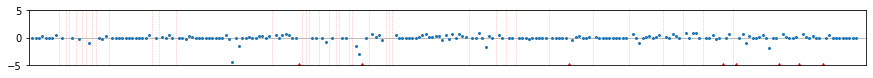

In [149]:
fig, ax = plt.subplots(figsize=(15, 1))

under_limit = -5
upper_limit =  5

#Prevent zero division
#gt = gt + 0.00000001

percentages = (gt-pred)/gt


outliers_bottom = percentages<under_limit
outliers_top = percentages>upper_limit



plt.plot((gt-pred)/gt, marker="o", markersize=2, linestyle="")
plt.vlines(np.where(NaNs), ymin=under_limit, ymax=upper_limit, colors='red', ls='--', lw=0.5, alpha=0.3)
plt.plot(np.where(outliers_bottom, under_limit-0.02, np.NaN),  marker="^", markersize=4, linestyle="", color='red')
plt.plot(np.where(outliers_top, upper_limit-0.02, np.NaN),  marker="v", markersize=4, linestyle="", color='red')

ax.set_ylim([under_limit, upper_limit])
ax.set_xlim([-1, 250])
#ax.set_ylim([under_limit+1.5, upper_limit+0.5])

plt.grid(axis='y')

plt.tick_params(
   axis='x',          
   which='both',      
   bottom=False,      
   top=False,         
   labelbottom=False) 

#fig.savefig('test.pdf', format='pdf', dpi=1200, bbox_inches='tight')

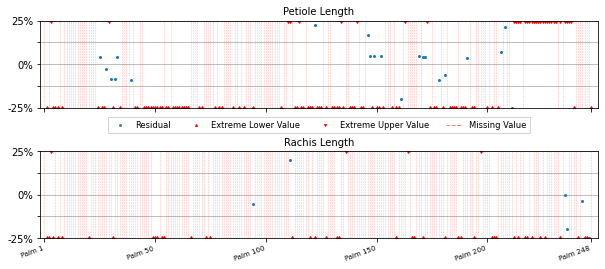

In [311]:
columns = ['MaxStemHeight_m', 'MaxStemDia_cm']
names = ['Stem Height', 'Stem Diameter']

columns = ['MaxLeafNumber', 'Max_Blade_Length_m']
names = ['Number of Leaves', 'Leaf Blade Length']

columns = ['AverageFruitLength_cm', 'MinFruitLength_cm', 'MaxFruitLength_cm']
names = ['Average Fruit Length', 'Minimal Fruit Length', 'Maximal Fruit Length']

columns = ['AverageFruitWidth_cm', 'MinFruitWidth_cm', 'MaxFruitWidth_cm']
names = ['Average Fruit Width', 'Minimal Fruit Width', 'Maximal Fruit Width']

columns = ['Max_Petiole_length_m', 'Max_Rachis_Length_m']
names = ['Petiole Length', 'Rachis Length']

under_limit = -25
upper_limit =  25

fig, ax = plt.subplots(len(columns), figsize=(10, len(columns) * 2), sharex=True, sharey=True)

for idx, column in enumerate(columns):
    pred = df_own[column].values
    gt = df[column].values
    NaNs = np.isnan(pred)

    percentages = (gt-pred)/gt * 100 
    outliers_bottom = percentages < under_limit
    outliers_top = percentages > upper_limit
    
    ax[idx].plot(percentages, marker="o", markersize=2, linestyle="")
    ax[idx].vlines(np.where(NaNs), ymin=under_limit, ymax=upper_limit, colors='red', ls='--', lw=0.5, alpha=0.3)
    # Extreme values
    ax[idx].plot(np.where(outliers_bottom, under_limit-0.02, np.NaN),  marker="^", markersize=4, linestyle="", color='red')
    ax[idx].plot(np.where(outliers_top, upper_limit-0.02, np.NaN),  marker="v", markersize=4, linestyle="", color='red')

    ax[idx].set_ylim([under_limit, upper_limit])
    ax[idx].set_xlim([-2, 250])
    ax[idx].grid(axis='y')
    ax[idx].set_title(names[idx],fontsize=10)

    
# Set the ticks and ticklabels for all axes
plt.setp(ax, xticks=[0, 50, 100, 150, 200, 247], 
         xticklabels=['Palm 1', 'Palm 50', 'Palm 100', 'Palm 150', 'Palm 200', 'Palm 248'],
         yticks=[-25, -12.5, 0, 12.5, 25],
         yticklabels=['-25%', '',  '0%', '', '25%'])

plt.xticks(rotation=20, ha='right', fontsize=7)
plt.subplots_adjust(wspace=None, hspace=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='steelblue', markersize=2, linestyle="", lw=2, label='Residual',),
                   Line2D([0], [1], marker="^", color='red',  markersize=2, linestyle="", label='Extreme Lower Value'),
                   Line2D([0], [2], marker="v", color='red',  markersize=2, linestyle="", label='Extreme Upper Value'),
                   Line2D([0], [3], color='red', ls='--', lw=1, alpha=0.5, label='Missing Value')]

ax[-1].legend(handles=legend_elements, loc='center',  ncol=4, bbox_to_anchor=(0.5, 1.30), fancybox=False, fontsize='small', frameon=True)

fig.savefig('petioleANDrachis_values.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [157]:
# fig, ax = plt.subplots(figsize=(10, 10))

# # some example data
# x = pred[~NaNs]
# y = gt[~NaNs]

# # pick a sigma and mu for normal distribution
# sigma = .51
# mu = 1

# # generate normally distributed samples
# noise = sigma * np.random.randn(len(x)) + mu

# # plot with original data points
# #plt.scatter(x,y, color = 'r')
# # plot with normally distributed random displacement
# plt.scatter(x + noise, y, s=10)
# #ax.set_aspect('equal', 'box')
# #fig.savefig('scatter_LeavesNumber.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))

# sns.regplot(x,y, color ='blue', truncate=False, x_jitter=1)

# ax.set_ylim([-1, 50])
# ax.set_xlim([-1, 50])



# Shapes

In [ ]:
df_own['FruitShape'] = df_own['FruitShape'].fillna('WRONG')

shapes_own = df_own['FruitShape'].values
shaped_gt  = df['FruitShape'].values

NaNs = shapes_own == 'WRONG'

In [ ]:
NaNs[NaNs == True].shape

In [ ]:
cm = confusion_matrix(shaped_gt[~NaNs], shapes_own[~NaNs])
df_cm = pd.DataFrame(cm)

In [ ]:
cm

In [ ]:
#np.unique(shapes_own[~NaNs], return_counts=True)

In [ ]:
#np.unique(shaped_gt[~NaNs], return_counts=True)

In [ ]:
#sns.set(font_scale=1.4) # for label size

fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

sns.heatmap(df_cm, annot=True, cmap=cmap, 
            square=True, linewidths=.5, cbar=False)#fmt='g')

ax.yaxis.set_ticklabels(np.unique(shapes_own[~NaNs]), rotation=0)
ax.xaxis.set_ticklabels(np.unique(shapes_own[~NaNs]))
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

#fig.savefig('confusion_matrix_shapes.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
print(precision_recall_fscore_support(shaped_gt, shapes_own, average='weighted'))
print(f1_score(shaped_gt, shapes_own, average='weighted'))


# Colors

In [26]:
# df_own['MainFruitColors'] = df_own['MainFruitColors'].apply(pd.Series).iloc[:, 0].fillna('WRONG').values

# colors_own =  df_own['MainFruitColors'].apply(pd.Series).iloc[:, -1].values
# colors_gt  = df['MainFruitColors'].str.split('; ').str[-1].values

# NaNs = colors_own == 'WRONG'

In [36]:
#df['MainFruitColors']

In [95]:
# CHEATING?
colors_own = []
colors_gt = []
for idx, value in enumerate(df['MainFruitColors'].str.split('; ').values):
    color = list(set(value) & set(df_own['MainFruitColors'].values[idx]))
    #print(color)
    if color:
        colors_own.append(color[0])
        colors_gt.append(color[0])
    else:
        colors_gt.append(value[0])
        try:
            colors_own.append(df_own['MainFruitColors'].values[idx][0])
        except:
            colors_own.append('Missing')
            
colors_own = np.array(colors_own)
colors_gt = np.array(colors_gt)
NaNs = colors_own == 'Missing'

#colors_own = colors_own[np.where(colors_own != 'WRONG')]

In [131]:
cm = confusion_matrix(colors_gt[~NaNs], colors_own[~NaNs])
new_order = [0, 2, 6, 4, -1, -2, 3, 1, 5]
cm_new = cm[:, new_order][new_order]
df_cm = pd.DataFrame(cm_new)
#df_cm = pd.DataFrame(cm)

In [132]:
unique, counts = np.unique(colors_own, return_counts=True)

In [133]:
colors = unique[1:]

In [134]:
labels = [colors[i] for i in new_order]

In [135]:
#labels

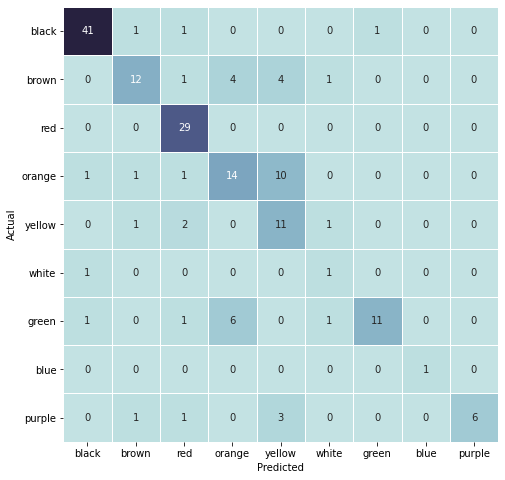

In [136]:
#sns.set(font_scale=1.4) # for label size

fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

sns.heatmap(df_cm, annot=True, cmap=cmap, 
            square=True, linewidths=.5, cbar=False)#fmt='g')

ax.yaxis.set_ticklabels(labels, rotation=0)
ax.xaxis.set_ticklabels(labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig.savefig('confusion_matrix_colours.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [137]:
print(precision_recall_fscore_support(colors_gt, colors_own, average='weighted'))
print(f1_score(colors_gt, colors_own, average='weighted'))


(0.7702063841176744, 0.5080645161290323, 0.5944844219818344, None)
0.5944844219818344
